In [1]:
from lib.utils import * # Import custom utility functions
import gymnasium as gym
from pogema import GridConfig
from stable_baselines3 import DQN
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Set Global parameters
GRID_SIZE = 16
DENSITY = 0.5
OBS_RADIUS = 5
MAX_EPISODE_STEPS = 64
SAVE_PARAMS_PATH = 'saved/tuned_params.yml'
SAVE_METRICS_PATH = 'saved/evaluation_metrics.yml'
MODEL_NAME = 'DQN_B'
MAX_TRIALS = 1000                                   # For evaluation_metrics()

grid_config = GridConfig(
    size=GRID_SIZE,                                 # size of the grid map 8 = (8x8)
    density=DENSITY,                                # obstacle density
    num_agents=1,                                   # number of agents
    obs_radius=OBS_RADIUS,                          # defines field of view
    max_episode_steps=MAX_EPISODE_STEPS,            # time horizon
    seed=None                                       # set to None for random obstacles, agents and targets positions at each reset
)

env = gym.make("Pogema-v0",grid_config=grid_config)

/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: -1.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


### DQN

Sources: 

* https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html
* https://github.com/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/dqn_sb3.ipynb
* https://github.com/araffin/rl-tutorial-jnrr19/blob/sb3/1_getting_started.ipynb
* https://stable-baselines3.readthedocs.io/en/master/guide/tensorboard.html
    * https://stable-baselines3.readthedocs.io/en/master/common/logger.html#logger
    * https://www.tensorflow.org/tensorboard/get_started
    * https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/dqn.yml - Tuned Hyperparams for several gym envs (Hard Problem)

In [2]:
# load tuned hyperparameters into DQN model for agent training
model_params = get_model_log(MODEL_NAME, SAVE_PARAMS_PATH)
# add additional params for logging of agent training
extra_params = {
    "env":env,
    "tensorboard_log":"./tensorboard"
}
model_params.update(extra_params)
model = load_model_params(DQN, model_params)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:231: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.92GB > 2.77GB
  warnings.warn(


In [3]:
# Evaluate untrained agent using env
val_env = gym.make("Pogema-v0",grid_config=grid_config)

val_dqn_model = DQN(
    "MlpPolicy",
    val_env,
    verbose=1
)

mean_reward, std_reward = evaluate_policy(
    val_dqn_model,
    val_dqn_model.get_env(),
    deterministic=True,
    n_eval_episodes=MAX_EPISODE_STEPS,
)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:231: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.92GB > 1.52GB
  warnings.warn(


mean_reward: 0.00 +/- 0.00


In [4]:
# Train agent and save it
model.learn(total_timesteps=int(3.0e5), tb_log_name=f"dqn_baseline_{MODEL_NAME}")
model.save(f"saved/dqn_baseline_{MODEL_NAME}")

Logging to ./tensorboard/dqn_baseline_DQN_B_1


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.2     |
|    ep_rew_mean      | 0.5      |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8672     |
|    time_elapsed     | 0        |
|    total_timesteps  | 169      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.4     |
|    ep_rew_mean      | 0.5      |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9782     |
|    time_elapsed     | 0        |
|    total_timesteps  | 331      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41       |
|    ep_rew_mean      | 0.5      |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes       

### Load trained agent and evaluate it

In [5]:
model = DQN.load(f"saved/dqn_baseline_{MODEL_NAME}")

env.reset()
mean_reward, std_reward = evaluate_policy(model, env, deterministic=True, n_eval_episodes=20)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:0.90 +/- 0.30


/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:231: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.92GB > 2.86GB
  warnings.warn(
/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [6]:
from IPython.display import SVG, display

metrics = evaluate_metrics(model, env, MODEL_NAME, num_episodes=MAX_EPISODE_STEPS, num_trials=MAX_TRIALS, verbose=False, save_animation=True)
save_metrics(metrics, MODEL_NAME, SAVE_METRICS_PATH)
print(f"Agent Success Rate: {metrics['success_rate'] * 100:.2f}%")
print(f"Steps to termination : {metrics['step_array']}")
print(f"Average steps to termination : {metrics['ave_steps']}")

Agent Success Rate: 81.50%
Steps to termination : [3, 8, 9, 4, 2, 3, 4, 5, 4, 4, 1, 1, 1, 3, 6, 1, 3, 3, 2, 2, 3, 40, 6, 3, 1, 2, 3, 4, 2, 4, 1, 1, 2, 4, 18, 1, 3, 2, 6, 1, 2, 5, 2, 3, 4, 6, 2, 3, 7, 5, 24, 1, 4, 1, 5, 2, 4, 1, 3, 1, 6, 10, 1, 1, 11, 6, 4, 3, 5, 4, 2, 1, 2, 1, 1, 2, 2, 8, 4, 1, 3, 5, 3, 1, 2, 5, 2, 4, 54, 1, 12, 9, 2, 3, 1, 2, 3, 1, 1, 3, 1, 34, 2, 4, 4, 1, 3, 2, 2, 2, 2, 3, 2, 2, 9, 1, 2, 5, 57, 4, 6, 3, 9, 4, 3, 5, 4, 1, 8, 5, 34, 3, 2, 6, 1, 1, 3, 1, 5, 3, 3, 5, 3, 4, 4, 43, 1, 8, 2, 48, 3, 1, 2, 2, 5, 2, 2, 2, 2, 1, 3, 4, 2, 4, 7, 2, 1, 4, 4, 1, 2, 1, 1, 2, 1, 3, 1, 6, 2, 2, 3, 9, 1, 6, 4, 7, 2, 4, 3, 2, 2, 1, 4, 2, 5, 3, 5, 7, 1, 1, 1, 3, 2, 2, 3, 5, 3, 3, 7, 1, 1, 2, 5, 3, 1, 2, 1, 1, 4, 1, 5, 3, 27, 1, 7, 4, 3, 1, 5, 2, 2, 3, 57, 2, 1, 3, 5, 1, 4, 2, 4, 1, 2, 1, 3, 1, 1, 3, 1, 1, 8, 1, 3, 4, 4, 21, 1, 3, 6, 4, 9, 2, 1, 2, 9, 2, 6, 1, 2, 1, 4, 2, 2, 3, 1, 5, 1, 6, 3, 3, 2, 3, 1, 2, 1, 2, 1, 12, 5, 3, 1, 1, 9, 3, 7, 11, 2, 1, 4, 1, 7, 3, 3, 1, 1, 3, 6, 6, 3, 2, 1,

### Load Animation

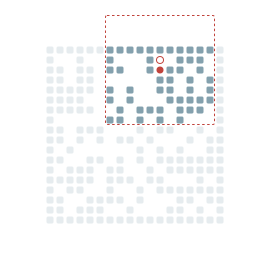

In [7]:
display(SVG(f'renders/render_{MODEL_NAME}.svg'))

### Tensorboard

In [8]:
%tensorboard --logdir tensorboard/dqn_baseline_DQN_A_1